# DSI Assessment 2 - Quantified Self

This assignment will be using the CRISP DM Framework to complete the project

<b> Contents Page

* Business Understanding
* Data Knowledge
* Data Processing
* Data Exploration
* 
</b>

## Business Understanding

## Data Preprocessing

This part is about exporting the information and processing it in a matter which can be later processed and explored

In [90]:
import pandas as pd # Data Munging tool
import os # Operating System functionality
import glob # Finds all pathnames e.g(.json)
from sklearn.feature_extraction.text import TfidfVectorizer # Combines both Count Vectorizer and Tfidf Transformer
import re # Regular Expression
import matplotlib.pyplot as plt
import seaborn as sns
#from nltk.

plt.style.use('ggplot')
%matplotlib inline

In [52]:
users = pd.read_json("users.json")

In [53]:
path_to_json = 'C:/users/jchung/desktop/D-Matrix/'
json_dir = os.listdir(path_to_json)
#del json_dir[0] ### do this step only if u have a mac and need to get rid of .DS Store folder
df3 = pd.DataFrame()
for file in json_dir:
    if ".json" not in file: 
        print (file)
        all_files = glob.glob(os.path.join(path_to_json + file + '/', "*.json"))
        df = pd.concat((pd.read_json(f) for f in all_files)) 
        df['channel'] = file
        df['ts'] = pd.to_datetime(df['ts'],unit='s')
        df2 = pd.DataFrame(df, columns = ['user','ts','channel','text'])
        df3 = df3.append(df2)
    else:
        print "File contains .json"

36100-dsi
36100-dsi-photos
36103-statistics
36106-dam
File contains .json
crisp-businessknow
crisp-dataknow
crisp-dataprep
crisp-deploy
crisp-eval
crisp-modelling
dam
dsi
dsi-assignment-2a
general
File contains .json
jira-discussion
python_instructions
random
story-telling
File contains .json


Below Script is from Martin and need to incorporate this into my script

In [ ]:
```# -*- coding: utf-8 -*-
"""
Created on Thu May 5 00:04:29 2016
@author: Dmatrix
"""
import csv
import datetime
import os
import re
import sys
import nltk
import ijson
crisp_mapper = {
    'crisp-businessknow': 'Business Understanding',
    'crisp-dataknow': 'Data Understanding',
    'crisp-dataprep': 'Data Preparation',
    'crisp-modelling': 'Modelling',
    'crisp-eval': 'Evaluation',
    'crisp-deploy': 'Deployment',
    'story-telling': 'Deployment',
    '36100-dsi': 'General',
    '36100-dsi-photos': 'General',
    '36103-statistics': 'General',
    '36106-dam': 'General',
    'dsi-assignment-2a': 'General',
    'random': 'General',
    'general': 'General'
}
user_mapper = {
    'u0weaa087': 'Data Scientist 2',
    'u0wdyeg6s': 'Business Analyst',
    'u0x443ckz': 'Data Scientist 1',
    'u0wfhmem8': 'Data Analytics Manager',
    'u0x6cuq3d': 'Project Manager',
    'u13aj8evd': 'Bender the Scrum Master',
    'howdy': 'Bender the Scrum Master',
    'duhita': 'Business Analyst',
    'jared': 'Data Scientist 2',
    'martin': 'Project Manager',
    'hussam': 'Data Analytics Manager',
    'chris': 'Data Scientist 1',
    'chris.garces': 'Data Scientist 1',
    'martinlehmann': 'Project Manager',
    'ravi': 'Consultant'
}
def extract(directory='.\data'):
    """Extract timestamp, user, text features from slack extracts
    Args:
        directory: The root directory folder where the slack extracts are located.
    Returns:
        a list of lists where each list contains the timestamp, user and text data.
        Ignores Bot Messages that are not Howdy
        Ignores File Comments
        Ignores Channel creation messages
        Ignores Channel purpose messages
        Ignores file shares
    """
    slack_records = []
    row_filter = ['file_comment', 'bot_message', 'channel_purpose', 'channel_join', 'file_share']
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            crisp_activity = subdir.split("\\")[2]  # HACK: get channel data
            with open(os.path.join(subdir, file)) as json_file:
                records = ijson.items(json_file, '')
                for record in records:
                    for message in record:
                        if message.get('subtype') in row_filter and message.get('username') != 'howdy':
                            continue
                        user = message.get('user')
                        # check if user is howdy
                        if message.get('subtype') == 'bot_message' and user is None:
                            user = message.get('username')
                        current_record = [message.get('ts'),
                                          user,
                                          message.get('text'),
                                          crisp_mapper.get(crisp_activity)]
                        slack_records.append(current_record)
    return slack_records
def first_pass_cleaning(slack_records):
    """ Transforms the slack record input addressing:
        1) Transform slack timestamp to date
        2) Transform email for positive sentiment of sharing
        3) Transform links for positive sentiment of sharing
        4) Remove unnecessary links from Howdy Bot
        5) Mask user information to project role
        6) Lower case words
        7) Sorts records by time
        8) Convert to ascii
        spelling, abbreviations
    Args:
        slack_records: Raw input from slack extract.
    Returns:
        A list of cleaned data representing each slack message.
    """
    for slack_record in slack_records:
        # transform timestamp to date
        slack_record[0] = timestamp_to_datetime(slack_record[0])
        # transform email
        slack_record[2] = mail_to_text(slack_record[2])
        # Slack links to be changed to "Sharing a link!"
        # exclamation for positive sentiment, sharing should be viewed positively
        slack_record[2] = links_to_text(slack_record[2])
        # Remove Bender's comments that are not english
        slack_record[2] = bender_to_english(slack_record[2])
        # transform user
        slack_record[1] = user_mapper.get(str.lower(slack_record[1]))
        # decode data
        slack_record[2] = slack_record[2].encode('utf-8').decode('ascii', 'ignore')
    # sort records by time
    slack_records.sort(key=lambda x: datetime.datetime.strptime(x[0], '%Y-%m-%d %H:%M:%S'))
    # convert to bag of words / or sentences
    bag_of_words_list = []
    #spelling
    #abbreviation
    for slack_record in slack_records:
        # lower case message
        slack_record[2] = str.lower(slack_record[2])
        # mask user in message
        for key, value in user_mapper.items():
            slack_record[2] = slack_record[2].replace(key, value)
        # Slack calling out a user: Replace "<@user>:" with "user," or "<@user>" with "user"
        for key, value in user_mapper.items():
            slack_record[2] = slack_record[2].replace(str.format("<@{0}>:", value), str.format("{0},", value))
            slack_record[2] = slack_record[2].replace(str.format("<@{0}>", value), str.format("{0}", value))
    #TODO
    return slack_records
def replace_code_with_semantic_intent(message):
    # if messasge contains : { [ ] }
    nltk.tokenize(message)
    return ""
def bender_to_english(message):
    return re.sub(r'<http://(d-matrix.)?howdy.ai/([a-zA-ez]+/)+([a-zA-Z]|[0-9])+[|]',
                  '',
                  message,
                  re.I)
def links_to_text(message):
    return re.sub(r'((ht)|(f))tp[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
                  'Sharing a link!',
                  message,
                  re.I)
def mail_to_text(message):
    return re.sub(r'(mailto:)?[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+',
                  'Here is my email!',
                  message,
                  re.I)
def timestamp_to_datetime(timestamp):
    return datetime.datetime.fromtimestamp(float(timestamp)).strftime('%Y-%m-%d %H:%M:%S')
def write_to_csv(records, output_file):
    """Writes list of slack records to CSV
        Args:
            records: The list containing all the messages
            output_file: the filename csv output
    """
    with open(output_file, 'w', newline='', encoding='utf-8') as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quotechar='"')
        writer.writerows(records)
        #for record in records:
            #writer.writerow([x.encode('utf-8') for x in record])
         #   writer.writerow(record)
def write_output_to_csv(bag_of_words_list, output_file):
    """Writes list of bag of words to CSV
    Args:
        bag_of_words_list: The list containing all the bag of words
        output_file: the filename csv output
    """
    with open(output_file, 'wb') as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quotechar='"')
        for bag_of_words in bag_of_words_list:
            writer.writerow(bag_of_words)  # TODO
def main(source_directory, output_file):
    slack_records = extract(source_directory)
    #bag_of_words_list = transform(slack_records)
    slack_records = first_pass_cleaning(slack_records)
    write_to_csv(slack_records, output_file)
if __name__ == '__main__':
    main(sys.argv[1], sys.argv[2])

In [31]:
re.I?

In [ ]:
def preprocessing(s):
    
    s = re.sub(r'<http://(d-matrix.)?howdy.ai/([a-zA-ez]+/)+([a-zA-Z]|[0-9])+[|]','',s,re.I)
    s = re.sub(r'((ht)|(f))tp[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','Sharing a link!',s,
                  re.I)
    
    

### Tokenizing

In [ ]:
def tokeniser(s):
    

### Stemming and Lemmatizing

http://www.lnse.org/papers/134-I3007.pdf

Stemming:

Lemmatizing:

In [ ]:
lemma = WordNetLemmatizer()

def lemma_tokens(tokens, lemma):
    lemmatized = []
    for item in tokens:
        lemmatized.append(lemma.lemmatize(item))
    return lemmatized

### Tf-idf

In [56]:
#data = pd.merge(df3,users,left_on='user',right_on='id',how='inner')
data = data[['user','ts','channel','text','name']]

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2940 entries, 0 to 2939
Data columns (total 5 columns):
user       2940 non-null object
ts         2940 non-null datetime64[ns]
channel    2940 non-null object
text       2940 non-null object
name       2940 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 137.8+ KB


In [58]:
data.head()

,user,ts,channel,text,name
0,U0WEAA087,2016-04-03 23:32:26.000002,36100-dsi,<@U0WEAA087|jared> has joined the channel,jared
1,U0WEAA087,2016-04-03 23:32:27.000003,36100-dsi,<@U0WEAA087|jared> set the channel purpose: Ch...,jared
2,U0WEAA087,2016-04-04 10:24:28.000009,36100-dsi,Yeah trying to get it done. I'm hoping to smas...,jared
3,U0WEAA087,2016-04-11 06:07:57.000119,36100-dsi,"Hey Guys, sorry haven't been that active. I'm ...",jared
4,U0WEAA087,2016-04-11 06:11:39.000120,36100-dsi,<http://nicomiceli.com/slackalytics/> I might ...,jared


In [27]:
df3.channel.value_counts()

crisp-dataprep         1159
36100-dsi               542
general                 301
crisp-businessknow      249
36106-dam               147
python_instructions     138
dsi-assignment-2a       135
crisp-dataknow          116
story-telling            95
jira-discussion          91
crisp-modelling          66
random                   61
36100-dsi-photos         44
36103-statistics          6
crisp-deploy              5
crisp-eval                5
dam                       2
dsi                       2
dtype: int64

## Quantified self - Jared

In [71]:
jared = data[data.name == 'jared']

In [72]:
jared.head()

,user,ts,channel,text,name
0,U0WEAA087,2016-04-03 23:32:26.000002,36100-dsi,<@U0WEAA087|jared> has joined the channel,jared
1,U0WEAA087,2016-04-03 23:32:27.000003,36100-dsi,<@U0WEAA087|jared> set the channel purpose: Ch...,jared
2,U0WEAA087,2016-04-04 10:24:28.000009,36100-dsi,Yeah trying to get it done. I'm hoping to smas...,jared
3,U0WEAA087,2016-04-11 06:07:57.000119,36100-dsi,"Hey Guys, sorry haven't been that active. I'm ...",jared
4,U0WEAA087,2016-04-11 06:11:39.000120,36100-dsi,<http://nicomiceli.com/slackalytics/> I might ...,jared


In [73]:
jared.channel.value_counts()

crisp-dataprep         63
python_instructions    29
36100-dsi              21
36106-dam              17
general                13
crisp-businessknow     10
random                  7
story-telling           5
dsi-assignment-2a       1
36100-dsi-photos        1
crisp-dataknow          1
crisp-deploy            1
crisp-modelling         1
crisp-eval              1
jira-discussion         1
dtype: int64

### Ploting messages over time

In [108]:
jared.groupby(jared.ts.apply(lambda x: x.hour)).text.size()

ts
0     11
1     11
2      9
3      1
4      2
5      6
6     28
7      4
8     11
9     15
10    26
11    18
12     6
13     1
20     5
21     3
23    15
dtype: int64

TypeError: bar() takes at least 3 arguments (2 given)

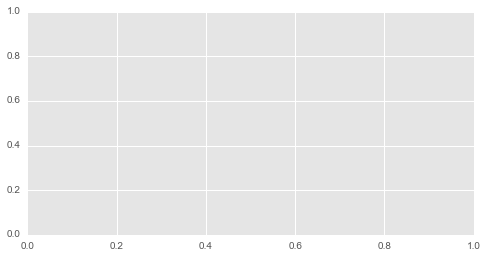

In [109]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.bar(jared.groupby(jared.ts.apply(lambda x: x.hour)).text.size())
fig.suptitle("Aggregated Hours",fontsize= 14)
ax.set_xlabel("Hours")
ax.set_xticks(jared.groupby(jared.ts.apply(lambda x: x.hour)).text.size().index)
ax.set_ylabel("Quantity")

In [110]:
ax.bar?